In [ ]:
'''
https://www.kaggle.com/code/rohankt/resnet-implementation-from-scratch-on-cifar10/output
^ download link
'''

In [1]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



In [ ]:

class Cifar10Batches(Dataset):
    def __init__(self, root, train=False, normalize=True):

        self.root = root
        self.train = train
        self.normalize = normalize

        files = []
        if train:
            files = [f"data_batch_{i}" for i in range(1, 6)]
        else:
            files = ["test_batch"]

        data_list, labels_list = [], []
        for fname in files:
            path = os.path.join(root, fname)
            with open(path, "rb") as f:
                entry = pickle.load(f, encoding="bytes")

            data_list.append(entry[b"data"])
            labels_list.extend(entry[b"labels"])

        data = np.concatenate(data_list, axis=0)
        self.labels = np.array(labels_list, dtype=np.int64)

        data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
        self.data = data

        self.mean = np.array([0.4914, 0.4822, 0.4465], dtype=np.float32).reshape(1,3,1,1)
        self.std  = np.array([0.2470, 0.2435, 0.2616], dtype=np.float32).reshape(1,3,1,1)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.normalize:
            x = (x - self.mean) / self.std
        y = self.labels[idx]
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)



In [ ]:

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
import torch.nn.functional as F


class LambdaLayer(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Identity()
        if stride != 1 or in_planes != planes:
            ch_pad = planes - in_planes
            self.shortcut = LambdaLayer(
                lambda x: F.pad(
                    x[:, :, ::stride, ::stride],
                    (0, 0, 0, 0, 0, ch_pad),  # pad channels
                    mode="constant",
                    value=0.0
                )
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.relu(out + self.shortcut(x))
        return out





In [ ]:

def resnet56_cifar(num_classes=10):
    return CifarResNet([9, 9, 9], num_classes=num_classes)



In [ ]:
def load_checkpoint(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)

    if isinstance(ckpt, dict) and "state_dict" in ckpt:
        state = ckpt["state_dict"]
    elif isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        state = ckpt["model_state_dict"]
    elif isinstance(ckpt, dict) and "model" in ckpt:
        state = ckpt["model"]
    else:
        state = ckpt

    state = {k.replace("module.", ""): v for k, v in state.items()}


    remapped = {}
    for k, v in state.items():
        k2 = k

        if k2.startswith("bn."):
            k2 = "bn1." + k2[len("bn."):]

        if k2.startswith("stage1."):
            k2 = "layer1." + k2[len("stage1."):]
        elif k2.startswith("stage2."):
            k2 = "layer2." + k2[len("stage2."):]
        elif k2.startswith("stage3."):
            k2 = "layer3." + k2[len("stage3."):]

        remapped[k2] = v


    remapped = {k: v for k, v in remapped.items() if not k.endswith("num_batches_tracked")}

    # load
    missing, unexpected = model.load_state_dict(remapped, strict=False)
    print("Loaded checkpoint with strict=False")
    print("Missing keys (showing up to 10):", missing[:10])
    print("Unexpected keys (showing up to 10):", unexpected[:10])

    model.eval()
    return model


In [6]:

def get_params_vector(model):
    return torch.cat([p.detach().flatten() for p in model.parameters()])

def set_params_vector(model, vec):
    offset = 0
    for p in model.parameters():
        numel = p.numel()
        p.data.copy_(vec[offset:offset+numel].view_as(p))
        offset += numel

def random_direction_like(model, device):
    v = torch.cat([torch.randn_like(p, device=device).flatten() for p in model.parameters()])
    v = v / (v.norm() + 1e-12)
    return v


In [ ]:
@torch.no_grad()
def eval_loss(model, loader, criterion, device, max_batches=10):
    model.eval()
    total_loss = 0.0
    total_n = 0

    for bi, (x, y) in enumerate(loader):

        if max_batches is not None and bi >= max_batches:
            break

        # move to device
        x = x.to(device)
        y = y.to(device)

        if x.dim() == 5 and x.size(1) == 1:
            x = x.squeeze(1)

        # extra safety check
        if x.dim() != 4:
            raise RuntimeError(f"Bad input shape for CNN: {x.shape}")

        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_n += bs

    return total_loss / max(total_n, 1)


In [ ]:
def random_direction_weight_scaled(model, device):
    chunks = []
    for p in model.parameters():
        r = torch.randn_like(p, device=device)
        r = r * (p.detach().norm() / (r.norm() + 1e-12) + 1e-12)
        chunks.append(r.flatten())
    return torch.cat(chunks)




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# CIFAR ResNet-56

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3,
                     stride=stride, padding=1, bias=False)

class LambdaLayer(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)

        # CIFAR ResNet Option-A shortcut
        self.shortcut = nn.Identity()
        if stride != 1 or in_planes != planes:
            ch_pad = planes - in_planes
            self.shortcut = LambdaLayer(
                lambda x: F.pad(
                    x[:, :, ::stride, ::stride],
                    (0, 0, 0, 0, 0, ch_pad),
                    mode="constant",
                    value=0.0
                )
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.relu(out + self.shortcut(x))
        return out


class CifarResNet(nn.Module):
    def __init__(self, layers, num_classes=10):
        super().__init__()
        self.in_planes = 16
        self.conv1 = conv3x3(3, 16)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, layers[0], stride=1)
        self.layer2 = self._make_layer(32, layers[1], stride=2)
        self.layer3 = self._make_layer(64, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, planes, blocks, stride):
        layers = [BasicBlock(self.in_planes, planes, stride)]
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


def resnet56_cifar(num_classes=10):
    return CifarResNet([9,9,9], num_classes)





C:\Users\AJ\AppData\Local\Temp\ipykernel_12268\1452032626.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Loaded checkpoint with strict=False
Missing keys (showing up to 10): []
Unexpected keys (showing up to 10): []
row 1/31 done
row 2/31 done
row 3/31 done
row 4/31 done
row 5/31 done
row 6/31 done
row 7/31 done
row 8/31 done
row 9/31 done
row 10/31 done
row 11/31 done
row 12/31 done
row 13/31 done
row 14/31 done
row 15/31 done
row 16/31 done
row 17/31 done
row 18/31 done
row 19/31 done
row 20/31 done
row 21/31 done
row 22/31 done
row 23/31 done
row 24/31 done
row 25/31 done
row 26/31 done
row 27/31 done
row 28/31 done
row 29/31 done
row 30/31 done
row 31/31 done
Z min/max: 0.3982714 178113500000.0 range: 178113495040.0
Saved: Z.npy, xs.npy, ys.npy


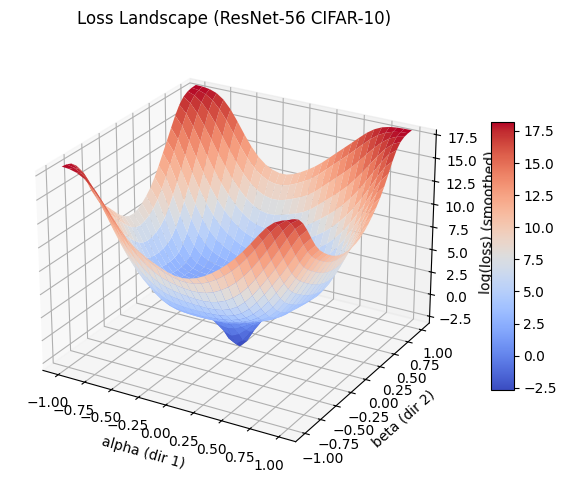

Saved loss_landscape_smooth.png


In [ ]:
def main():
    # EDIT these if not in directory
    ckpt_path = r"resnet56_cifar10.pth"
    cifar_batches_root = r"cifar-10-batches-py"

    device = "cuda" if torch.cuda.is_available() else "cpu"

    testset = Cifar10Batches(cifar_batches_root, train=False, normalize=True)
    testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=0)

    model = resnet56_cifar(num_classes=10).to(device)
    model = load_checkpoint(model, ckpt_path, device)

    criterion = nn.CrossEntropyLoss()

    w0 = get_params_vector(model).clone()
    d1 = random_direction_weight_scaled(model, device)
    d2 = random_direction_weight_scaled(model, device)

    xmin, xmax, xsteps = -1.0, 1.0, 31
    ymin, ymax, ysteps = -1.0, 1.0, 31
    xs = np.linspace(xmin, xmax, xsteps)
    ys = np.linspace(ymin, ymax, ysteps)

    Z = np.zeros((ysteps, xsteps), dtype=np.float32)

    for i, beta in enumerate(ys):
        for j, alpha in enumerate(xs):
            w = w0 + alpha * d1 + beta * d2
            set_params_vector(model, w)
            Z[i, j] = eval_loss(model, testloader, criterion, device, max_batches=None)
        print(f"row {i+1}/{ysteps} done")

    set_params_vector(model, w0)

    print("Z min/max:", Z.min(), Z.max(), "range:", float(Z.max() - Z.min()))

    np.save("Z.npy", Z)
    np.save("xs.npy", xs)
    np.save("ys.npy", ys)
    print("Saved: Z.npy, xs.npy, ys.npy")

    from scipy.ndimage import gaussian_filter

    cap = np.percentile(Z, 95)
    Z_clip = np.clip(Z, Z.min(), cap)
    Z_log = np.log(Z_clip - Z_clip.min() + 1e-6)
    Z_smooth = gaussian_filter(Z_log, sigma=1.2)

    X, Y = np.meshgrid(xs, ys)
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(
        X, Y, Z_smooth,
        cmap="coolwarm",
        linewidth=0,
        antialiased=True,
        shade=True
    )

    ax.set_xlabel("alpha (dir 1)")
    ax.set_ylabel("beta (dir 2)")
    ax.set_zlabel("log(loss) (smoothed)")
    ax.set_title("Loss Landscape (ResNet-56 CIFAR-10)")

    ax.view_init(elev=25, azim=-60)
    ax.set_zlim(Z_smooth.min(), np.percentile(Z_smooth, 98))

    fig.colorbar(surf, shrink=0.6, aspect=12)
    plt.tight_layout()
    plt.savefig("loss_landscape_smooth.png", dpi=300)
    plt.show()

    print("Saved loss_landscape_smooth.png")

    return Z, xs, ys


# in notebook do this so variables persist:
Z, xs, ys = main()





